# <span style="color:#ff4238;">__DATA 200 Midterm Project__</span>

#### Authors: Brandon Chan, Lucas Duncan, Owen Macgowan, Brayden Van De Wynckel

#### Date: February 2024

![Friends](https://qph.cf2.quoracdn.net/main-qimg-55f2935b1d162eb07783e02013ca66e9-lq)

---
## <span style="color:#42a2d6;">__Summary of Contents__</span>
#### __Our midterm project will cover the following topics:__
1. Background and Purpose
2. Importing Libraries
3. Data Retrieval and Data Cleaning
4. Visualization
5. Modeling
6. Conclusions


# <span style="color:#f6be00;">__1. Background and Purpose__</span>
In this project, we will delve into datasets that contain detailed information about the content and tone of dialogue spoken by the six main members of the Friends cast. Our focus will be on examining the ratio of dialogue that includes outward exclamation, whether indicated by exclamation marks or capital letters denoting shouting or excitement. Additionally, we will analyze the ratio of exclaimed dialogue directed towards specific characters, identified through references to their names.

Our goal is to explore whether a correlation exists between the overall use of exclamation, its distribution among different characters, its directed usage towards specific characters, and the resulting episode rating and viewership. This analysis will shed light on the impact of emphatic dialogue on the reception and popularity of each episode.

## <span style="color:#f6be00;">__1.1 Research Question__</span>
### How does the frequency of exclamation either from or directed towards the six main characters in the series Friends correlate with viewer ratings across various episodes?



# <span style="color:#ff4238;">__2. Imports__</span>
#### This section imports all of the required components for data cleaning, visualization, and modeling.

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model as lm
import matplotlib.pyplot as plt

# <span style="color:#42a2d6;">__3. Data Retrieval and Data Cleaning__</span>
#### In this section, we use regex, split-apply-combine, and other useful data cleaning techniques to analyze multiple sources of information that we have joined together.

In [2]:
dialogue = pd.read_csv(("https://raw.githubusercontent.com/"
    "rfordatascience/tidytuesday/master/data/"
    "2020/2020-09-08/friends.csv"))

episodes = pd.read_csv(("https://raw.githubusercontent.com/"
    "rfordatascience/tidytuesday/master/data/"
    "2020/2020-09-08/friends_info.csv"))

print("EXAMPLE DIALOGUE:")
dialogue.head(5)

print("EXAMPLE EPISODE INFO:")
episodes.head(5)

EXAMPLE DIALOGUE:
EXAMPLE EPISODE INFO:


,season,episode,title,directed_by,written_by,air_date,us_views_millions,imdb_rating
0,1,1,The Pilot,James Burrows,David Crane & Marta Kauffman,1994-09-22,21.5,8.3
1,1,2,The One with the Sonogram at the End,James Burrows,David Crane & Marta Kauffman,1994-09-29,20.2,8.1
2,1,3,The One with the Thumb,James Burrows,Jeffrey Astrof & Mike Sikowitz,1994-10-06,19.5,8.2
3,1,4,The One with George Stephanopoulos,James Burrows,Alexa Junge,1994-10-13,19.7,8.1
4,1,5,The One with the East German Laundry Detergent,Pamela Fryman,Jeff Greenstein & Jeff Strauss,1994-10-20,18.6,8.5


In [3]:
# Filters out rows that aren't dialogue
all_character_dialogue = dialogue[~dialogue["speaker"].isin(["Scene Directions", "#ALL#", "NA"])]

# Our analysis will focus on the 6 main characters
main_character_names = ["Ross Geller", "Monica Geller",
                        "Phoebe Buffay", "Chandler Bing",
                        "Joey Tribbiani", "Rachel Green"]

# Filters out dialogue by non-main characters
main_character_dialogue = dialogue[dialogue["speaker"].isin(main_character_names)]

main_character_dialogue.head(10)

,text,speaker,season,episode,scene,utterance
0,There's nothing to tell! He's just some guy I ...,Monica Geller,1,1,1,1
1,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,1,1,1,2
2,"All right Joey, be nice. So does he have a hum...",Chandler Bing,1,1,1,3
3,"Wait, does he eat chalk?",Phoebe Buffay,1,1,1,4
5,"Just, 'cause, I don't want her to go through w...",Phoebe Buffay,1,1,1,6
6,"Okay, everybody relax. This is not even a date...",Monica Geller,1,1,1,7
7,Sounds like a date to me.,Chandler Bing,1,1,1,8
9,"Alright, so I'm back in high school, I'm stand...",Chandler Bing,1,1,1,10
11,"Then I look down, and I realize there's a phon...",Chandler Bing,1,1,1,12
12,Instead of...?,Joey Tribbiani,1,1,1,13


In [4]:
# *************************************************************
# This section is about creating a DataFrame
# with a row for every season, episode, and main character
#
# (Our method seems complicated but is required,
# as not every main character has dialogue in every episode)
#
# "Episode_Dialogue" = The quantity of dialogue per episode/season
#
# *************************************************************

# Creates a row for every episode in every season
master_list = all_character_dialogue.groupby(["season", "episode"]).agg("size").reset_index(name="Episode_Dialogue")

# Adds a column to explode (breaking into a row for every character in the list)
master_list["speaker"] = [main_character_names] * len(master_list)
master_list = master_list.explode('speaker')
master_list = master_list[["season", "episode", "speaker", "Episode_Dialogue"]]

master_list.head(10)

,season,episode,speaker,Episode_Dialogue
0,1,1,Ross Geller,292
0,1,1,Monica Geller,292
0,1,1,Phoebe Buffay,292
0,1,1,Chandler Bing,292
0,1,1,Joey Tribbiani,292
0,1,1,Rachel Green,292
1,1,2,Ross Geller,241
1,1,2,Monica Geller,241
1,1,2,Phoebe Buffay,241
1,1,2,Chandler Bing,241


In [5]:
# *******************************************************************************************************
# This section finds how frequently characters' dialogue is exclamative
#
# "Speaker_Dialogue" = quantity of dialogue per speaker/episode/season
# "Speaker_Exclaim"  = quantity of exclamative dialogue per speaker/episode/season
# "Episode_Exclaim"  = The quantity of exclamative dialogue per episode/season
#
# *******************************************************************************************************

# Determines Speaker_Dialogue
speaker_dialogue_data = main_character_dialogue.groupby(["speaker", "season", "episode"]).agg("size").reset_index(name="Speaker_Dialogue")


In [6]:
# Finds indices of all dialogue with uppercase letters or "!"
upper_case_word = main_character_dialogue['text'].str.contains(r'[A-Z]{2,}')
contains_exclamation_mark = main_character_dialogue['text'].str.contains(r'!')
all_indices_to_keep = upper_case_word | contains_exclamation_mark

# Determines Episode_Exclaim
episode_exclaim_data = main_character_dialogue[all_indices_to_keep].groupby(["season", "episode"]).size().reset_index(name="Episode_Exclaim")

# Determines Speaker_Exclaim
speaker_exclaim_data = main_character_dialogue[all_indices_to_keep].groupby(["season", "episode", "speaker"]).size().reset_index(name="Speaker_Exclaim")

# Joins this data into master
master_list = pd.merge(master_list, episode_exclaim_data, on=["season", "episode"], how="left")
master_list = pd.merge(master_list, speaker_dialogue_data, on=["season", "episode", "speaker"], how="left")
master_list = pd.merge(master_list, speaker_exclaim_data, on=["season", "episode", "speaker"], how="left")

master_list = master_list.fillna(0)

master_list.head(10)


,season,episode,speaker,Episode_Dialogue,Episode_Exclaim,Speaker_Dialogue,Speaker_Exclaim
0,1,1,Ross Geller,292,67,47,8.0
1,1,1,Monica Geller,292,67,73,20.0
2,1,1,Phoebe Buffay,292,67,19,5.0
3,1,1,Chandler Bing,292,67,39,8.0
4,1,1,Joey Tribbiani,292,67,39,11.0
5,1,1,Rachel Green,292,67,48,15.0
6,1,2,Ross Geller,241,35,68,10.0
7,1,2,Monica Geller,241,35,28,5.0
8,1,2,Phoebe Buffay,241,35,14,9.0
9,1,2,Chandler Bing,241,35,16,2.0


In [7]:
#*****************************************************************************************************
# This Section Is About Finding How Often Certain Characters' Names Are Included Within Exclamative Dialogue
#
#   "Episode_Exclaimed_Toward" = Quantity of exclamative dialogue containing
#                                some main character's name, per episode/season
#   "Speaker_Exclaimed_Toward" = Quantity of exclamative dialogue containing
#                                this main character's name, per speaker/episode/season
#
#******************************************************************************************************

# Starts by finding all rows with exclamation
acd_copy = all_character_dialogue[all_character_dialogue['text'].str.contains(r'[A-Z]{2,}') |
                                  all_character_dialogue['text'].str.contains(r'!')]

# For exclamation rows whose text contains the name of a main character, strip away non-name portion
for name in main_character_names:
    contains_name = acd_copy['text'].str.contains(name.split(" ")[0])
    acd_copy.loc[contains_name, 'text'] = name

# Obtain all rows whose text contains the name of a main character
filtered_dialogue = acd_copy[acd_copy["text"].isin(main_character_names)]

# Modify columns, then group
filtered_dialogue = filtered_dialogue.drop(columns=["speaker", "scene"])
filtered_dialogue = filtered_dialogue.rename(columns={"text": "speaker"})

# Finds the total amount of exclamative dialogue towards each main character
episode_exclaimed_toward = filtered_dialogue.groupby(["season", "episode"]).agg("size").reset_index(name="Episode_Exclaimed_Toward")

In [8]:
# Find the total amount of exclamative dialogue by speaker
speaker_exclaimed_toward = filtered_dialogue.groupby(["season", "episode", "speaker"]).agg("size").reset_index(name="Speaker_Exclaimed_Toward")

# Merge with master
master_list = pd.merge(master_list, episode_exclaimed_toward, on=["season", "episode"], how="left")
master_list = pd.merge(master_list, speaker_exclaimed_toward, on=["season", "episode", "speaker"], how="left")

# Fill missing values with 0
master_list = master_list.fillna(0)

master_list.head(10)

,season,episode,speaker,Episode_Dialogue,Episode_Exclaim,Speaker_Dialogue,Speaker_Exclaim,Episode_Exclaimed_Toward,Speaker_Exclaimed_Toward
0,1,1,Ross Geller,292,67,47,8.0,10.0,3.0
1,1,1,Monica Geller,292,67,73,20.0,10.0,3.0
2,1,1,Phoebe Buffay,292,67,19,5.0,10.0,0.0
3,1,1,Chandler Bing,292,67,39,8.0,10.0,0.0
4,1,1,Joey Tribbiani,292,67,39,11.0,10.0,2.0
5,1,1,Rachel Green,292,67,48,15.0,10.0,2.0
6,1,2,Ross Geller,241,35,68,10.0,2.0,0.0
7,1,2,Monica Geller,241,35,28,5.0,2.0,2.0
8,1,2,Phoebe Buffay,241,35,14,9.0,2.0,0.0
9,1,2,Chandler Bing,241,35,16,2.0,2.0,0.0


In [9]:
# Join with the episode info table
master_list = pd.merge(master_list, episodes, on=["season", "episode"], how="left")

# Since we are primarily focusing on rating and views, we can drop other unnecessary columns
master_list = master_list.drop(columns=["title", "directed_by", "written_by", "air_date"])

master_list.head(10)

,season,episode,speaker,Episode_Dialogue,Episode_Exclaim,Speaker_Dialogue,Speaker_Exclaim,Episode_Exclaimed_Toward,Speaker_Exclaimed_Toward,us_views_millions,imdb_rating
0,1,1,Ross Geller,292,67,47,8.0,10.0,3.0,21.5,8.3
1,1,1,Monica Geller,292,67,73,20.0,10.0,3.0,21.5,8.3
2,1,1,Phoebe Buffay,292,67,19,5.0,10.0,0.0,21.5,8.3
3,1,1,Chandler Bing,292,67,39,8.0,10.0,0.0,21.5,8.3
4,1,1,Joey Tribbiani,292,67,39,11.0,10.0,2.0,21.5,8.3
5,1,1,Rachel Green,292,67,48,15.0,10.0,2.0,21.5,8.3
6,1,2,Ross Geller,241,35,68,10.0,2.0,0.0,20.2,8.1
7,1,2,Monica Geller,241,35,28,5.0,2.0,2.0,20.2,8.1
8,1,2,Phoebe Buffay,241,35,14,9.0,2.0,0.0,20.2,8.1
9,1,2,Chandler Bing,241,35,16,2.0,2.0,0.0,20.2,8.1


# <span style="color:#f6be00;">__4. Visualization__</span>
#### In this component of our project, we use the data that we cleaned to create graphs that help show the relationship between our findings.

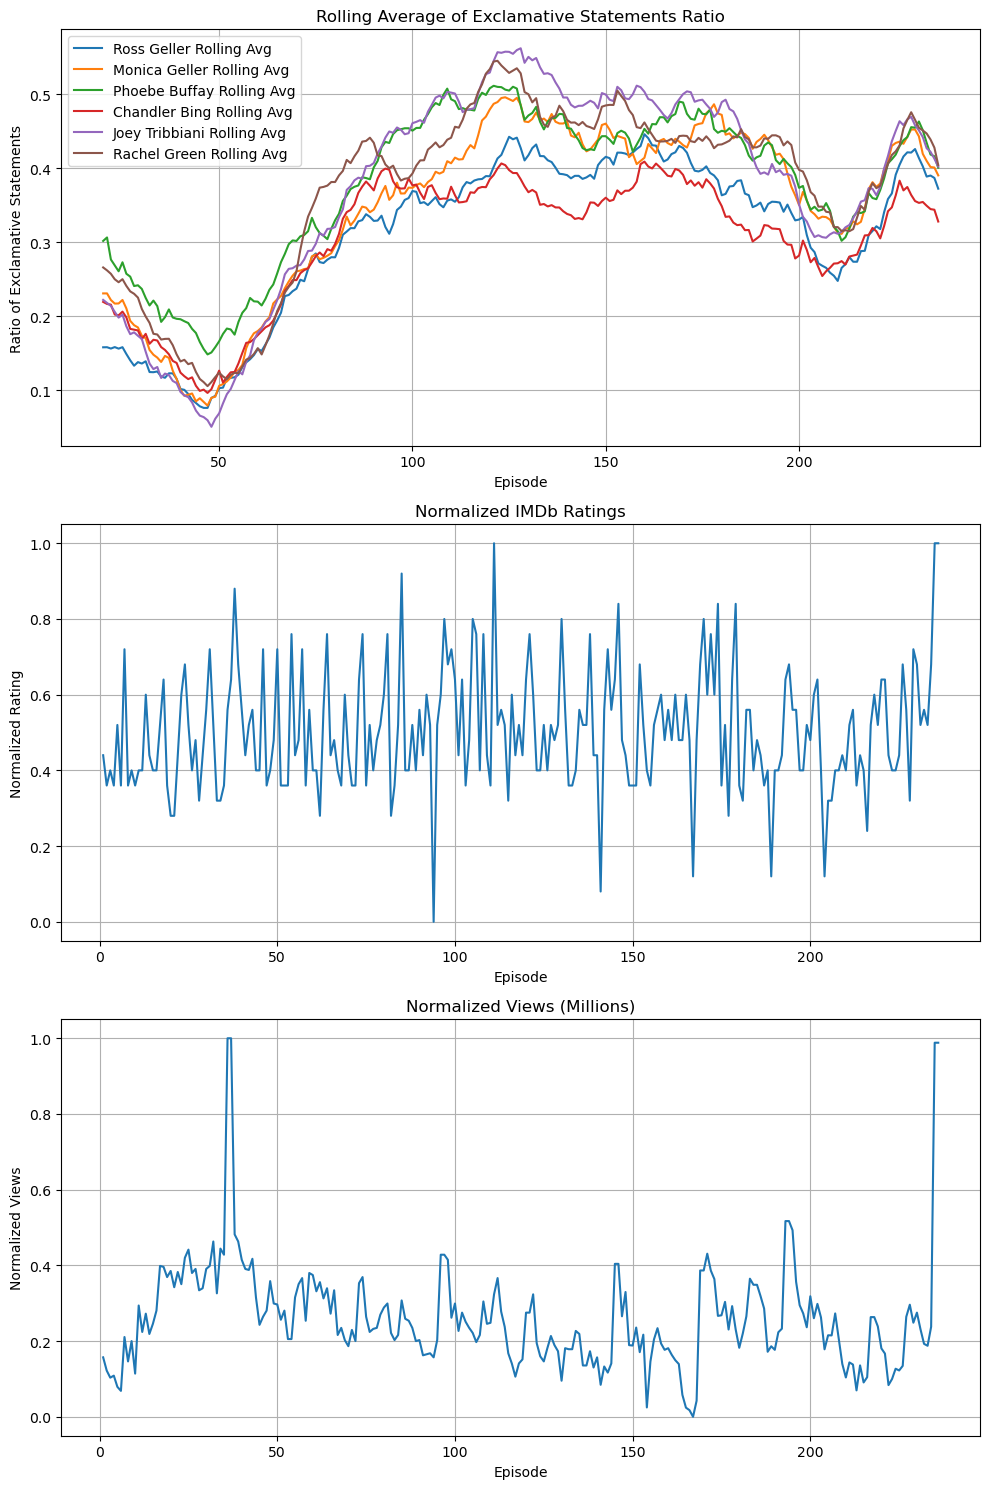

In [14]:
fig, axs = plt.subplots(3, figsize=(10, 15))

# Create a list to store all rolling averages
all_rolling_avgs = []

for name in main_character_names:
    all_rows_of_character = master_list[master_list["speaker"] == name].copy()  # Make a copy of the DataFrame

    # Calculating the ratio of Exclamative Statements per episode
    all_rows_of_character.loc[:, "av_speaker_ex"] = all_rows_of_character["Speaker_Exclaim"] / all_rows_of_character["Speaker_Dialogue"]

    # Creating Moving Average
    rolling_avg = all_rows_of_character["av_speaker_ex"].rolling(window=20).mean()
    all_rolling_avgs.append(rolling_avg)

    # Plotting all lines for the rolling averages subplot
    axs[0].plot(range(1, len(all_rows_of_character) + 1), rolling_avg, label=f"{name} Rolling Avg")

# Normalizing and plotting only one line for ratings (first character)
axs[1].plot(range(1, len(all_rows_of_character) + 1),
            (all_rows_of_character["imdb_rating"] - all_rows_of_character["imdb_rating"].min()) /
            (all_rows_of_character["imdb_rating"].max() - all_rows_of_character["imdb_rating"].min()), label=f"{main_character_names[0]} IMDb Rating")

# Normalizing and plotting only one line for views (first character)
axs[2].plot(range(1, len(all_rows_of_character) + 1),
            (all_rows_of_character["us_views_millions"] - all_rows_of_character["us_views_millions"].min()) /
            (all_rows_of_character["us_views_millions"].max() - all_rows_of_character["us_views_millions"].min()), label=f"{main_character_names[0]} Views (Millions)")

# Labels for the rolling averages subplot
axs[0].set_title("Rolling Average of Exclamative Statements Ratio")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Ratio of Exclamative Statements")
axs[0].legend()
axs[0].grid(True)

# Labels for the IMDb ratings subplot with only one line
axs[1].set_title("Normalized IMDb Ratings")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Normalized Rating")
axs[1].grid(True)

# Labels for the views (in millions) subplot with only one line
axs[2].set_title("Normalized Views (Millions)")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Normalized Views")
axs[2].grid(True)

# Adjusting layout
plt.tight_layout()
plt.show()

# <span style="color:#ff4238;">__5. Modeling__</span>
#### For this segment, we took our data and created regression models to better understand trends that exist within our data.

### <span style="color:#ff4238;">__5.1 Models__</span>

In [11]:
# Create a dataframe for regression analysis
df_regr = (master_list
    .groupby(['episode', 'season'])
    .agg({'Speaker_Exclaim': 'sum', 'Speaker_Exclaimed_Toward': 'sum', 'us_views_millions': 'mean', 'imdb_rating': 'mean'})
    .reset_index()
)

# Perform linear regression for Speaker Exclamations vs us_views_millions
x1 = df_regr[['Speaker_Exclaim']]
y1 = df_regr['us_views_millions']

regr1 = lm.LinearRegression()
regr1.fit(x1, y1)

print("Speaker Exclamations vs views intercept:", regr1.intercept_)
print("Speaker Exclamations vs views coefficient (slope):", regr1.coef_)

####

# Perform linear regression for Speaker Exclamations vs imdb_rating
x2 = df_regr[['Speaker_Exclaim']]
y2 = df_regr['imdb_rating']

regr2 = lm.LinearRegression()
regr2.fit(x2, y2)

print("\nSpeaker Exclamations vs imdb intercept:", regr2.intercept_)
print("Speaker Exclamations vs imdb coefficient (slope):", regr2.coef_)

####

# Perform linear regression for Speaker Exclaimed Toward vs us_views_millions
x3 = df_regr[['Speaker_Exclaimed_Toward']]
y3 = df_regr['us_views_millions']

regr3 = lm.LinearRegression()
regr3.fit(x3, y3)

print("\nSpeaker Exclamations Toward vs viewership intercept:", regr3.intercept_)
print("Speaker Exclamations vs viewership coefficient (slope):", regr3.coef_)

####

# Perform linear regression for Speaker Exclaimed Toward vs imdb_rating
x4 = df_regr[['Speaker_Exclaimed_Toward']]
y4 = df_regr['imdb_rating']

regr4 = lm.LinearRegression()
regr4.fit(x4, y4)

print("\nSpeaker Exclamations Toward vs imdb intercept:", regr4.intercept_)
print("Speaker Exclamations Toward vs imdb coefficient (slope):", regr4.coef_)

Speaker Exclamations vs views intercept: 29.14979274879311
Speaker Exclamations vs views coefficient (slope): [-0.05016144]

Speaker Exclamations vs imdb intercept: 8.32236881689598
Speaker Exclamations vs imdb coefficient (slope): [0.00184553]

Speaker Exclamations Toward vs viewership intercept: 27.303528400413533
Speaker Exclamations vs viewership coefficient (slope): [-0.17640228]

Speaker Exclamations Toward vs imdb intercept: 8.323423792584613
Speaker Exclamations Toward vs imdb coefficient (slope): [0.01259064]


### <span style="color:#ff4238;">__5.2 Interpretation of the Coefficients__</span>

__1. Speaker Exclamations vs. Episode Viewership:__
   - Intercept: The intercept of approximately 29.15 suggests that when there are no speaker exclamations, the average viewership is around 29.15 million.
   - Coefficient (slope): The coefficient of approximately -0.05 indicates that for each additional speaker exclamation in an episode, the viewership decreases by about 0.05 million. This negative coefficient suggests that as the frequency of speaker exclamations increases, viewership tends to decrease slightly. However, this effect is relatively small.

__2. Speaker Exclamations vs. IMDb Rating:__
   - Intercept: The intercept of approximately 8.32 suggests that when there are no speaker exclamations, the average IMDb rating is around 8.32.
   - Coefficient (slope): The coefficient of approximately 0.0018 indicates that for each additional speaker exclamation in an episode, the IMDb rating increases by about 0.0018 points. This positive coefficient suggests that as the frequency of speaker exclamations increases, the IMDb rating tends to increase slightly. Similar to viewership, this effect is relatively small.

__3. Speaker Exclamations Toward vs. Episode Viewership:__
   - Intercept: The intercept of approximately 27.30 suggests that when there are no speaker exclamations toward a character, the average viewership is around 27.30 million. It's interesting to note that the average viewership number in this intercept is smaller than the viewership number from the first viewership analysis. This suggests that when excalmations towards characters are considered instead of general speaker excalmations, the average baseline viewership is lower.
   - Coefficient (slope): The coefficient of approximately -0.18 indicates that for each additional speaker exclamation directed toward a character in an episode, the viewership decreases by about 0.18 million. This negative coefficient suggests that as the frequency of speaker exclamations toward characters increases, viewership tends to decrease. This effect is slightly greater than the first analysis regarding episode viewership.

__4. Speaker Exclamations Toward vs. IMDb Rating:__
   - Intercept: The intercept of approximately 8.32 suggests that when there are no speaker exclamations directed toward characters, the average IMDb rating is around 8.32. This is the same average IMDb rating as our earlier analysis found when looking at IMDb ratings when there are no speaker excalmations.
   - Coefficient (slope): The coefficient of approximately 0.0126 indicates that for each additional speaker exclamation directed toward a character in an episode, the IMDb rating increases by about 0.0126 points. This positive coefficient suggests that as the frequency of speaker exclamations toward characters increases, the IMDb rating tends to increase. This effect, although small, is slightly more pronounced than the effect that normal speaker exclamations had on IMDb ratings.

### <span style="color:#ff4238;">__5.3 Plots__</span>

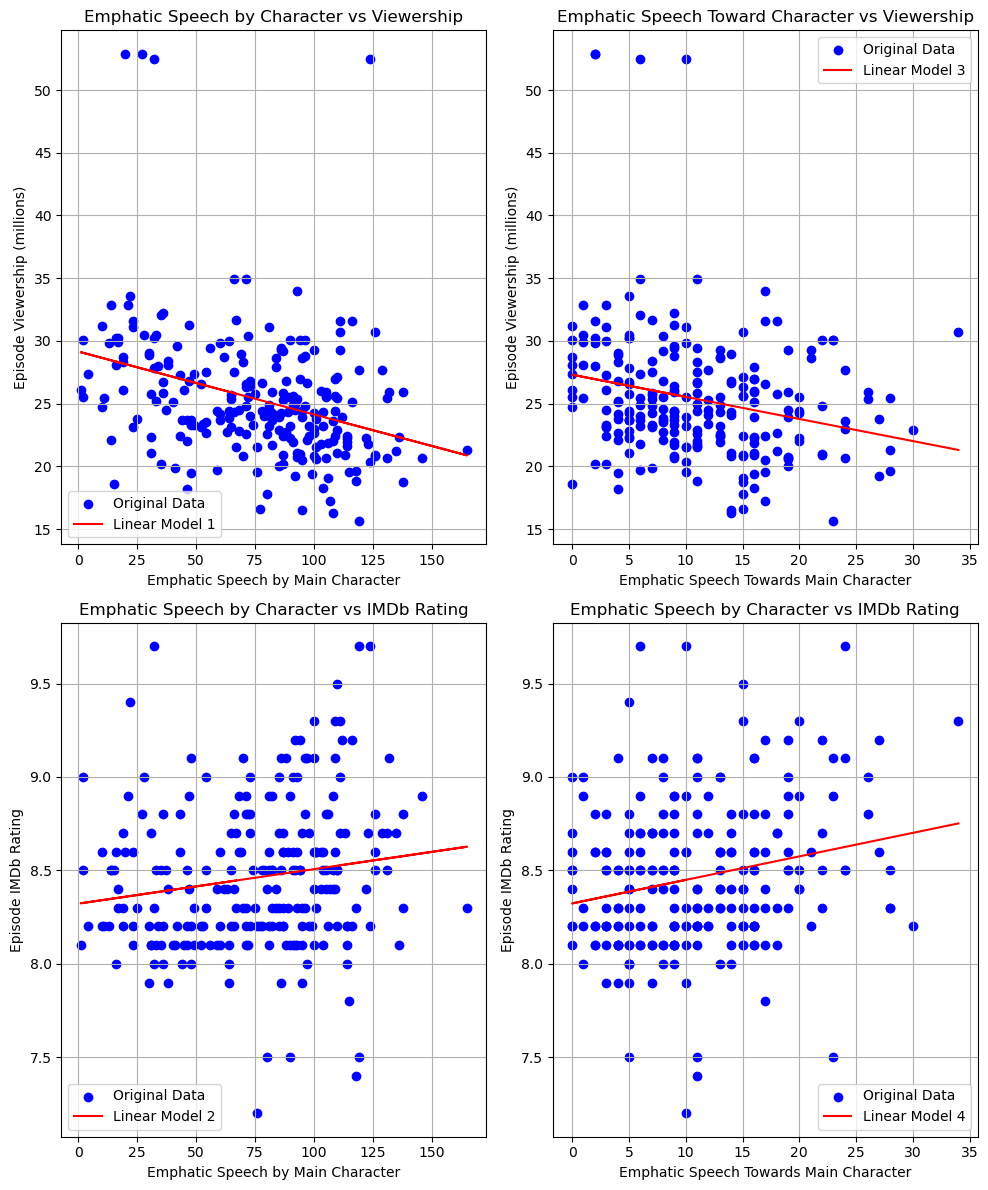

In [15]:
# Create subplots for regression analysis
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 12))

# Scatter plot and linear regression for Speaker Exclamations vs us_views_millions
ax[0][0].scatter(x1, y1, color='blue', label='Original Data')
ax[0][0].set_title("Emphatic Speech by Character vs Viewership")
ax[0][0].plot(x1, regr1.predict(x1), color='red', label='Linear Model 1')
ax[0][0].set_xlabel('Emphatic Speech by Main Character')
ax[0][0].set_ylabel('Episode Viewership (millions)')
ax[0][0].legend()
ax[0][0].grid(True)

# Scatter plot and linear regression for Speaker Exclamations vs imdb_rating
ax[1][0].scatter(x2, y2, color='blue', label='Original Data')
ax[1][0].set_title('Emphatic Speech by Character vs IMDb Rating')
ax[1][0].plot(x2, regr2.predict(x2), color='red', label='Linear Model 2')
ax[1][0].set_xlabel('Emphatic Speech by Main Character')
ax[1][0].set_ylabel('Episode IMDb Rating')
ax[1][0].legend()
ax[1][0].grid(True)

# Scatter plot and linear regression for Speaker Exclaimed Toward vs us_views_millions
ax[0][1].scatter(x3, y3, color='blue', label='Original Data')
ax[0][1].set_title('Emphatic Speech Toward Character vs Viewership')
ax[0][1].plot(x3, regr3.predict(x3), color='red', label='Linear Model 3')
ax[0][1].set_xlabel('Emphatic Speech Towards Main Character')
ax[0][1].set_ylabel('Episode Viewership (millions)')
ax[0][1].legend()
ax[0][1].grid(True)

# Scatter plot and linear regression for Speaker Exclaimed Toward vs imdb_rating
ax[1][1].scatter(x4, y4, color='blue', label='Original Data')
ax[1][1].set_title('Emphatic Speech by Character vs IMDb Rating')
ax[1][1].plot(x4, regr4.predict(x4), color='red', label='Linear Model 4')
ax[1][1].set_xlabel('Emphatic Speech Towards Main Character')
ax[1][1].set_ylabel('Episode IMDb Rating')
ax[1][1].legend()
ax[1][1].grid(True)

plt.tight_layout()
plt.show()

# <span style="color:#42a2d6;">__6. Conclusions__</span>

The models indicate two clear trends in the data. When main characters speak or are spoken to with emphatic speech, the IMDb rating increases, but the viewership falls. This indicates that reviewers enjoy increased emphatic speech, potentially because the characters are more expressive and engaging. However, the masses seem to feel the opposite way, and people tend to be less inclined to watch the show when the characters use emphatic speech. This could possibly be because characters come across as more irritating and less realistic.

Furthermore, going deeper into viewer preferences, we find a nuanced relationship. While reviewers may value the depth and emotion brought by emphatic speech, the broader audience might find it polarizing. This duality presents a unique challenge for the show's creators: balancing the desire for expressive dialogue that resonates with some viewers, while ensuring it remains accessible and engaging to the wider audience.

These findings show the difficulty of audience reception in the realm of entertainment. The creators of Friends have the difficult challenge of not just pleasing one group, but to find a balance that keeps both critics and the broader audience engaged.

As we progressed through this project, we encountered numerous difficult challenges. One significant issue was the problems we faced with our code. Ultimately, we had to make dozens of revisions and changes to ensure that our code functioned correctly. Although it was a long and strenuous process, we persevered and overcame these adversities to achieve a successful outcome.

This project has equipped us with numerous new skills that we can carry forward into the future. We now feel much more comfortable and adept at using markdown, and we have gained a deeper understanding of the processes involved in cleaning, retrieving, visualizing, and modeling data. Additionally, we have developed a clearer grasp of the data science lifecycle, having navigated through it for this project.

Moving forward, our plan is to continue working on this project beyond the scope of the class by delving deeper into various datasets related to Friends. Given the extensive number of episodes in the series, we believe there are countless intriguing connections waiting to be uncovered through further Exploratory Data Analyses (EDAs). Perhaps we will uncover trends in character popularity or identify which characters appear together most frequently. With ten seasons worth of data at our disposal, the questions we can explore are limited only by our imaginations.